# Estatísticas do Jogos Alite dado múltiplos indivíduos.

  - This file is part of  program Alite.
  - Copyright © 2023  Carlo Oliveira <carlo@nce.ufrj.br>.
  - [Labase](http://labase.selfip.org) - [NCE](http://portal.nce.ufrj.br) - [UFRJ](http://www.ufrj.br).
  - SPDX-License-Identifier: ([GNU General Public License v3.0 or later](https://www.gnu.org/licenses/gpl-3.0-standalone.html)).

## Version and configurations.

 This module retrieves data and plot statistics for the [Alite - Games](https://games.alite.selfip.org).

## [23.07](https://github.com/labase/data_edu/releases)

### Added

- Recover players and oids for them (21).
- Guess the longuest game to display for each player (24).



# Gera uma tabela com oids dos jogadores
Coleta dados do ALite e filtra os oids dos jogadores

## Formato de dados do JSON

### Tabela dos players

<a id="play"></a>
URL (../players)

O campo games é uma lista de *goals*/*trials* deste jogador

|-----|------|-----|------|-------|------|-------|
| _id | name | ano | sexo | idade | time | games |

 Campos da lista games do player

O campo *scorer* é um oid para referenciar os dados de um dado jogo

|------|------|-------|--------|
| game | goal | trial | scorer |

### Tabela do game (../game?oid=_game_oid_>)

O *game_oid* é um valor obtido de um campo scorer de uma lista do *players*

|-----|-------|
| _id | score |

### Tabela dos games (../games?oid=_player_oid_>)

|-----|------|------|------|-------|--------|
| _id | name | game | goal | trial | scorer |

### Tabela do scorer ou score API

|-------|------|------|-------|-------|------|
| carta | casa | move | ponto | valor | time |

## Significado das URLs para recuperar os dados

### Person URL

Recupera uma lista de todos os jogadores (../players).
Retorna uma [tabela dos players](#play)

# Seleciona jogos longos dos jogadores e grava em CSV

In [3]:
import urllib.request, json
from pandas import DataFrame
from datetime import datetime
from unidecode import unidecode
gaming_url='https://games.alite.selfip.org/score/game?oid={}'

class GamePlayers:
    def __init__(self, game_url='https://games.alite.selfip.org/score/players', game='wcst'):
        self.game_url = game_url
        self.game = game
        self.df: DataFrame = DataFrame()
        self.game_data = []

    def process_df(self):
        """ Shapes current dataframe to filter wisc and replace the column scorer

        :return:
        """
        then = datetime(2023, 6, 29)
        def play_count(scorer):
            scorer = scorer[10:-2]
            with urllib.request.urlopen(gaming_url.format(scorer)) as url_game:
                return len(json.loads(url_game.read().decode())["score"]), scorer
        def new(g):
            play_date = pd.to_datetime(g["time"]).tz_localize(None)
            return play_date > then

        def gamer(x):
            y = [play_count(gm["scorer"]) for gm in x if gm["game"]==self.game]
            # print(x, y)
            # return y[-1] if y  else ''
            return max(y)[1] if y  else ''

        def clean(x):
            x = unidecode(x.lower())
            return f"{n[0]} {n[1][:2]}." if len(n:=x.split()) >1  else x
        dfg_ = DataFrame(gd for gd in self.game_data if new(gd) and gd["games"]) # if gd["scorer"])
        dfg_["name"] = dfg_.name.apply(lambda x: clean(x))
        dfg_["wgame"] = dfg_.games.apply(lambda x: gamer(x))
        return dfg_

    def retrieve_games(self):
        """ Retrieve from remote source data for a given player

        :return: None
        """
        with urllib.request.urlopen(self.game_url) as urlp:
            self.game_data.extend(json.loads(urlp.read().decode()))
            df = self.process_df()[["_id", "name", "wgame"]]
            df = df.loc[df.wgame != '']
            df = df.drop_duplicates(subset=['name'], keep='last', inplace=False, ignore_index=True)
            df = df[~df.name.isin( "eu thimberly yuri".split())]
            df["oid"] = df.wgame
            df = df.drop(['_id',  "wgame"], axis=1)
        return df

    def go_users(self, u_file="wsct.csv"):
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            from pathlib import Path
            filepath = Path("./", u_file)
            fr = self.retrieve_games()
            fr.to_csv(filepath, index_label="user")
            print(filepath, fr)

GamePlayers().go_users()

wsct.csv              name                       oid
2           italo  64a46295b23753d1d92bcb99
3       julia al.  64a46ba3b23753d1d92bcba7
4          kaique  64a6e4a1b23753d1d92bcbb6
5        fernando  64a6e590b23753d1d92bcbb8
6   guilherme ga.  64a6e61bb23753d1d92bcbba
7   cristiano ro.  64a6e925b23753d1d92bcbc3
8      thimberlly  64a6e964b23753d1d92bcbc5
9         leandro  64a6eb2ab23753d1d92bcbc9
10        douglas  64a6ebd7b23753d1d92bcbcc
12          pedro  64a6edcbb23753d1d92bcbd2
13         dayane  64a6efe2b23753d1d92bcbd4
14        jessica  64a6f16db23753d1d92bcbd6
15         kauane  64a6f256b23753d1d92bcbd9
16        gustavo  64a6f3bcb23753d1d92bcbdb
17           ryan  64a6f48fb23753d1d92bcbdf
18       yuri da.  64a6fb63b23753d1d92bcbe6
19    william ba.  64a78bc7b23753d1d92bcbfc
20     labase an.  64ad6a06b23753d1d92bcc01
21        willian  64ad900eb23753d1d92bcc06
22     labase fa.  64b92b09b23753d1d92bcc08


# Gera um CSV com os dados de WISC de cada jogador

In [4]:
import pandas as pd

class GameData:
    def __init__(self, game_url='https://games.alite.selfip.org/score/game?oid={}'):
        self.game_url = game_url
        self.df: DataFrame = DataFrame()
        self.game_data = []
        self.count = 0

    def retrieve_games(self, player):
        """ Retrieve from remote source data for a given player

        :param player: Given player id; identification
        :return: None
        """
        user, name, oid = player
        with urllib.request.urlopen(self.game_url.format(oid)) as urlp:
            data = json.loads(urlp.read().decode())
            dat = data['score']
            [line.update(user=user, name=name) for line in dat]
            self.game_data.extend(dat)

    def load_all_persons(self):
        dfp = pd.read_csv("wsct.csv", header=0)
        games = [dfp.loc[k, :] for k in [2,3]]
        [self.retrieve_games(per) for per in games]
        print(self.game_data)
        self.df = DataFrame(self.game_data)
        self.df.to_csv("wsct_data.csv", index_label="index")
        return dfp


# gs = GameStats().person_load(['64ad8b55b23753d1d92bcc04'])
gs = GameData().load_all_persons()
print(gs)


[{'carta': 0, 'casa': 'no no no', 'move': 'no no no', 'ponto': '000', 'valor': '0000', 'time': '2023-07-06 12:58:31.562000', 'user': 4, 'name': 'kaique'}, {'carta': 1, 'casa': 'Um Triângulo Vermelho', 'move': 'Um Triângulo Verde', 'ponto': '000', 'valor': '0110', 'time': '2023-07-06 12:59:22.927000', 'user': 4, 'name': 'kaique'}, {'carta': 2, 'casa': 'Um Triângulo Vermelho', 'move': 'Quatro Cruzes Vermelhas', 'ponto': '100', 'valor': '1000', 'time': '2023-07-06 12:59:25.215000', 'user': 4, 'name': 'kaique'}, {'carta': 3, 'casa': 'Um Triângulo Vermelho', 'move': 'Dois Triângulos Azuis', 'ponto': '000', 'valor': '0100', 'time': '2023-07-06 12:59:27.466000', 'user': 4, 'name': 'kaique'}, {'carta': 4, 'casa': 'Um Triângulo Vermelho', 'move': 'Um Círculo Vermelho', 'ponto': '100', 'valor': '1010', 'time': '2023-07-06 12:59:27.698000', 'user': 4, 'name': 'kaique'}, {'carta': 5, 'casa': 'Um Triângulo Vermelho', 'move': 'Quatro Estrelas Verdes', 'ponto': '011', 'valor': '0000', 'time': '2023-0

## Plota dois subgraficos para indicar a permanência e as jogadas dos participantes nos games

{4, 5}


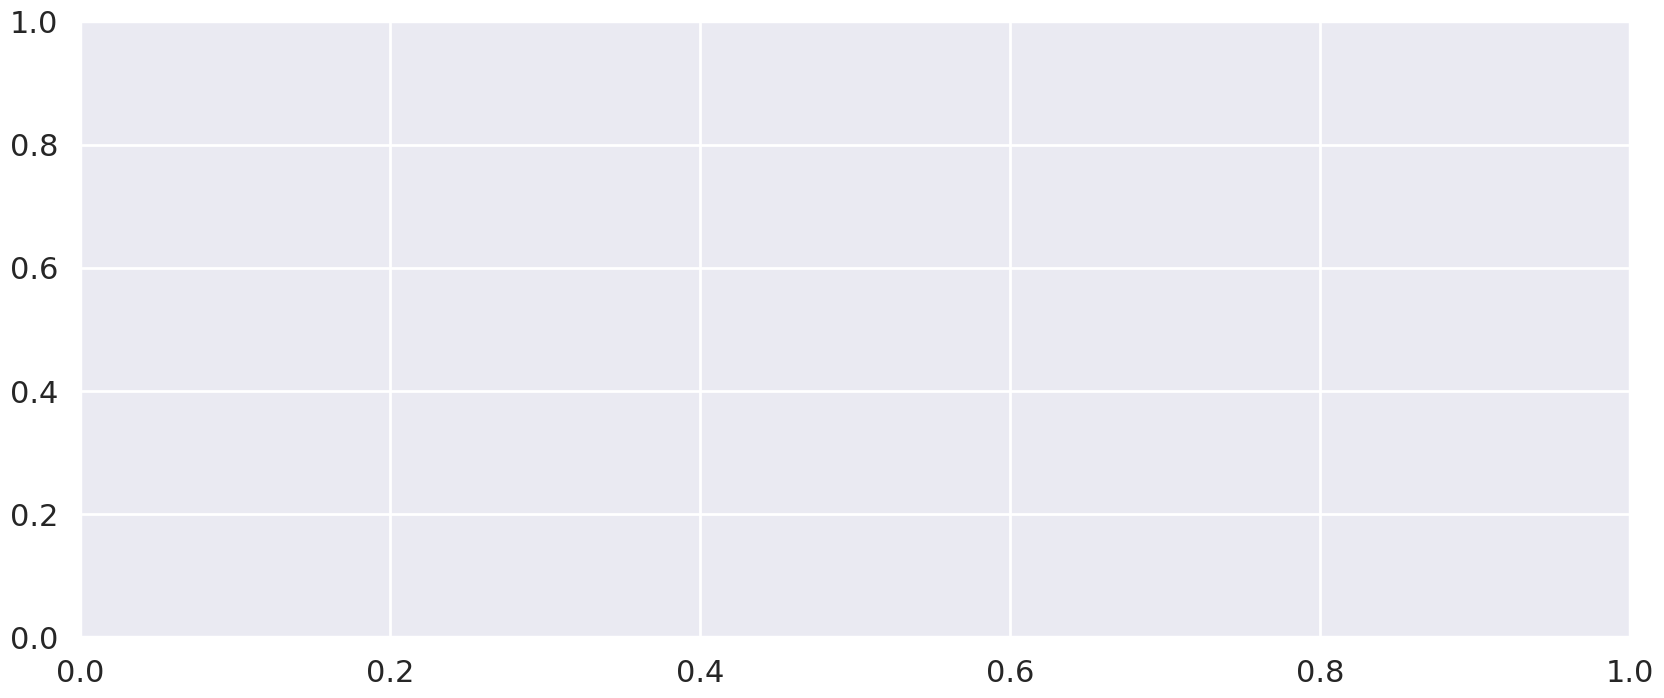

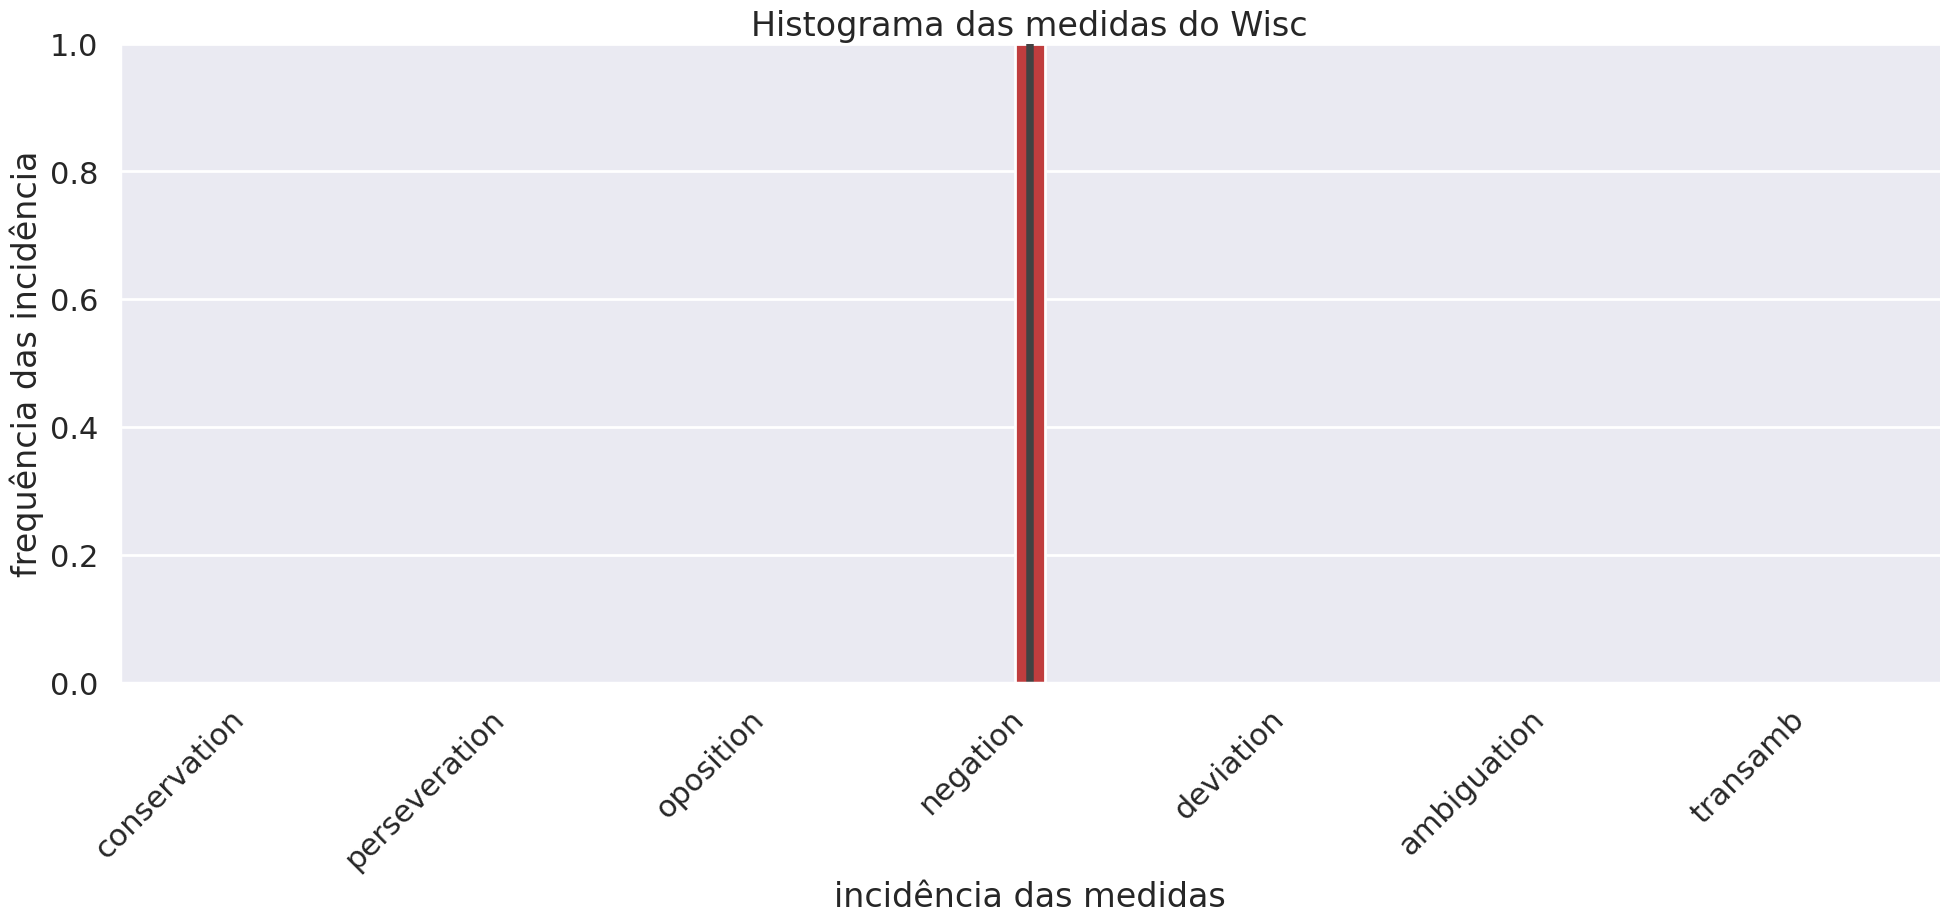

In [5]:
from pandas import DataFrame
from collections import namedtuple
from dataclasses import dataclass
import seaborn as sns
person =  '64ad8b55b23753d1d92bcc04' # Willian
person =  '64a6ec51b23753d1d92bcbce' # Thimberly
person =  '64a6efe0b23753d1d92bcbd3' # Dayane
person =  '64a6f3bab23753d1d92bcbda' # Gustavo
person =  '64a6e922b23753d1d92bcbc2' # Cristiano
person =  '64a6ebd4b23753d1d92bcbcb' # Douglas
person =  '64a6f20fb23753d1d92bcbd7' # Kauane
person =  '64a6e613b23753d1d92bcbb9' # Guilherme
person =  '64a4605cb23753d1d92bcb93' # italo
person =  '649d7851b9995c27c863da60' # Anni
person =  '64a46576b23753d1d92bcb9c' # Pedro
person =  '64a4694cb23753d1d92bcba5' # Julia
person =  '64a46826b23753d1d92bcba2' # Jessica
person =  '649f1732b9995c27c863da88' # Julia NO
person =  '649f17e0b9995c27c863da8c' # Fernando NO
person =  '649f05dcb9995c27c863da64' # leandro NO
person =  '64a6fadcb23753d1d92bcbe4' # Yury
person =  '64a6e579b23753d1d92bcbb7' # Fernando
person =  '64a6eb27b23753d1d92bcbc8' # leandro
person =  '64a78bc5b23753d1d92bcbfb' # William B
person =  '64a4694cb23753d1d92bcba5' # Julia A


@dataclass
class Plot:
    kind = "value plot factor violin hist heat".split()
    icon = [(6, 5), (6, 5), (3, 2), (6, 0), (2, 2), (5, 4)]
    value = dict(col='valor', title='Contagem dos Valores Wisc', ylabel='Contagem de Valores',
                 xlabel="Participantes", sub_title="Counting Plot de valores do teste Wisconsin")
    plot = dict(col='ponto', title='Contagem dos Pontos Wisc', ylabel='Contagem de Pontos',
                xlabel="Participantes", sub_title="Counting Plot de pontos do teste Wisconsin")
    factor = dict(col='ponto', title='Factor Plot das medidas do Wisc', ylabel='frequência das incidência',
                  xlabel="incidência das medidas", sub_title="Factor Plot do teste Wisconsin")
    violin = dict(col='ponto', title='Violin Plot das medidas do Wisc', ylabel='frequência das incidência',
                  xlabel="incidência das medidas", sub_title="Violin Plot do teste Wisconsin")
    hist = dict(col='ponto', title='Histograma das medidas do Wisc', ylabel='frequência das incidência',
                xlabel="incidência das medidas", sub_title="Histogram Plot do teste Wisconsin")
    heat = dict(col='ponto', title='Correlação das medidas do Wisc', ylabel='listagem das incidência',
                xlabel="listagem das medidas", sub_title="Heatmap Plot dos fatores no teste Wisconsin")
    plotting = dict(value=value, plot=plot, factor=factor, violin=violin, hist=hist, heat=heat)

import numpy as np
class WiscPlot:
    Cfplot = namedtuple("Cfplot", "col title ylabel xlabel")
    Pnt = namedtuple("Pnt", "ok no td")
    Val = namedtuple("Val", "cc cf cn ct")
    def __init__(self, game_url='https://games.alite.selfip.org/score/games?oid={}'):
        self.game_url = game_url
        self.df: DataFrame = DataFrame()
        self.game_data = []
        self.count = 0

    def retrieve_games(self, player):
        """ Retrieve from remote source data for a given player

        :param player: Given player id; identification
        :return: None
        """
        with urllib.request.urlopen(self.game_url.format(player)) as urlp:
            self.game_data.extend(json.loads(urlp.read().decode()))

    def get_all_games(self, plotter, conf, players_file="wsct_data.csv"):
        """ Get all games from a given player.

        :param players_file: Given player data file
        :return: None (assign to current df attribute)
        """
        df = pd.read_csv(players_file)
        groups = df.groupby(df.user)
        ks = set(groups.keys)
        print(ks)
        self.df = groups.get_group(4)
        self.df =self.df[["ponto", "valor",'carta', 'casa', 'move', 'time']]
        plotter(conf)
        # print(d_f)
        # [print(d) for d in groups.get_group(5)]
        # print(self.df)
        # print("shape: ",scorer.shape[0], len(scorer))
        return self

    def retrieve_oid_from_person_df(self, person_oid):
        """ Trim id vale from extra surroundings.

        :param person_oid: Given player identifier
        :return: self (this object)
        """
        import re
        # noinspection PyProtectedMember
        # oid_list = [re.findall(r"'(.+?)'", text)[0] for text in person_df._id.to_list()]
        self.get_all_games(person_oid)
        return self

    def refine_point_value_info(self):
        """ Extract some cognitive relevant properties from existing data,

        :return: transformed dataframe with new columns
        """

        def counter(a, b):
            """ Counts repetition of a figure.

            :param a: current figure of the series
            :param b: next figure of the series
            :return: count if prevails or zero if not
            """
            a, b = int(a), int(b)
            self.count += (1 if a else 0)
            count, self.count = self.count if not b else 0, 0 if not b else self.count
            return count

        def alter(a, b):
            a, b = int(a), int(b)
            no_alter = (a == b) or (b == 0) or (a == 0)
            self.count += (1 if a != b else 0)
            count, self.count = self.count if no_alter else 0, 0 if no_alter else self.count
            return count

        def nobother(cc, cf, cn, ct, ng=False):
            non = [int(cc), int(cf), int(cn)]
            do = non.pop(int(ct) % 3) < 1
            return int(not any(non) if ng else all(non)) if do else 0

        def noner(cc, cf, cn, ct):
            non = [int(cc), int(cf), int(cn)]
            do = non.pop(int(ct) % 3) < 1
            return (non[0] + 2 * non[1]) if do else 0

        def bother(cc, cf, cn, ct, e=True):
            cc, cf, cn, ct = int(cc), int(cf), int(cn), int(ct) % 3
            all_k = [cc, cf, cn]
            if ct > 2 or ct < 0:
                raise ValueError(ct)
            target = all_k.pop(ct)
            return target * sum(all_k) if e else int(all(all_k))

        point_list = [text if type(text) == str else "000" for text in self.df.ponto.to_list()]
        valor_list = [text if type(text) == str else "0000" for text in self.df.valor.to_list()]
        point_list = [self.Pnt(text[:-2], *list(text[-2:])) for text in point_list]
        new_list = point_list[1:] + [self.Pnt(0, 0, 0)]
        val_list0 = [self.Val(*list(text)) for text in valor_list]
        non_list = [noner(*list(val)) for val in valor_list]
        nob_list = [nobother(*list(val)) for val in valor_list]
        neg_list = [nobother(*list(val), ng=True) for val in valor_list]
        conservation = [counter(a.ok, b.ok) for a, b in zip(point_list, new_list)]
        perseveration = [counter(a.no, b.no) for a, b in zip(point_list, new_list)]
        deviation = [alter(a, b) for a, b in zip(non_list, non_list[1:] + [0])]
        oposition = [counter(a, b) for a, b in zip(nob_list, nob_list[1:] + [0])]
        negation = [counter(a, b) for a, b in zip(neg_list, neg_list[1:] + [0])]
        ambiguation = [bother(cc, cf, cn, ct) for cc, cf, cn, ct in val_list0]
        transamb = [bother(cc, cf, cn, ct, False) for cc, cf, cn, ct in val_list0]
        zipped = list(zip(conservation, perseveration, oposition, negation, deviation, ambiguation, transamb))
        columns = 'conservation perseveration oposition negation deviation ambiguation transamb'.split()
        df__ = DataFrame(zipped, columns=columns)
        _df = self.df.drop(columns='carta casa move time ponto valor'.split(),
                           inplace=False).reset_index()
        _df = _df.join(df__).drop(columns='index'.split(), inplace=False)
        # self.df = _df
        return _df

    def plot_template(self, cfg: Cfplot, runner, x_lim=None, y_lim=None, tick=False, tl= False, df=None):
        """ Template method to embrace a given method.

        :param tick: Add slant labels to x-axis.
        :param cfg: Plotting configuration
        :param runner: Given method to be templated.
        :param df: Dataframe source for plotting.
        :param x_lim: Limits for x-axis.
        :param y_lim: Limits for y-axis.
        :return: Plotting context.
        """
        from matplotlib import pyplot as plt_
        f = plt_.figure(figsize=(20, 8))
        ax = f.add_subplot(1, 1, 1)

        if df is None:
            df_ = self.refine_point_value_info()
            df_ = pd.melt(df_, var_name="measure", value_name="incidence")
        else:
            df_ = df
        chart_ = runner(df_, ax)
        _ = chart_.set(title=cfg.title, ylabel=cfg.ylabel, xlabel=cfg.xlabel)
        # _ = chart_.set_xticklabels(chart_.get_xticklabels(), rotation=45, horizontalalignment='right')
        chart_.set_xticklabels(chart_.get_xticklabels(), rotation=45, horizontalalignment='right') if tl else None
        _ = chart_.set_xticklabels(rotation=45, horizontalalignment='right') if tick else None
        chart_.set(xlim=x_lim) if x_lim else None
        chart_.set(ylim=y_lim) if y_lim else None
        # chart_.set_xlim(left=x_lim[0], right=x_lim[1]) if x_lim else None
        return plt_

    def plot(self, cfg: Cfplot):
        """ Counting bar plot

        :param cfg: Plotting configuration
        :return: Plotting context.
        """
        import seaborn as sbn
        # df_ = self.refine_point_value_info()
        return self.plot_template(cfg, lambda df__, a: sbn.countplot(data=df__, x="measure", hue=cfg.col),
                                  tl=True)

    def factorplot(self, cfg: Cfplot):
        """ Factor bar plot

        :param cfg: Plotting configuration
        :return: Plotting context.
        """
        import seaborn as sbn
        sbn.set_context('poster')
        return self.plot_template(cfg, lambda df_, a: sbn.catplot(
            x='measure', y='incidence', hue='measure', data=df_, kind='bar', height=8, aspect=2.5),
                                  tick=True, y_lim=(0, 1))

    def violinplot(self, cfg: Cfplot):
        """ Violin gaussian plot

        :param cfg: Plotting configuration
        :return: Plotting context.
        """
        import seaborn as sbn
        sbn.set_context('poster')
        return self.plot_template(cfg, lambda df_, a: sbn.violinplot(scale="width",
            x='measure', y='incidence', hue='measure', inner="quart", data=df_), y_lim=(-1, 2), tl=True)

    def histplot(self, cfg: Cfplot):
        """ Histogram bar plot

        :param cfg: Plotting configuration
        :return: Plotting context.
        """
        import seaborn as sbn
        return self.plot_template(cfg, lambda df_, a: sbn.histplot(
            data=df_, stat="count", multiple="dodge",
            x="incidence", kde=False,
            palette="pastel", hue="measure",
            element="bars", legend=True, ax=a),
                                  x_lim=(5, None), y_lim=(0, 8))

    def heatmap(self, cfg: Cfplot):
        """ Correlation map for cognition profiles

        :param cfg: Plotting configuration
        :return: Plotting context.
        """
        from matplotlib import pyplot as plt_
        import numpy as np
        plt_.figure(figsize=(15, 8))
        df_ = self.refine_point_value_info()
        # df_ = df_.drop(columns=['name'], inplace=False)
        # Compute the correlation matrix
        corr = df_.corr()
        # Generate a mask for the upper triangle
        mask = np.triu(np.ones_like(corr, dtype=bool))
        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
        # Draw the heatmap with the mask and correct aspect ratio
        # chart_ = sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
        chart_ = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                             square=True, linewidths=.5, cbar_kws={"shrink": .5})
        _ = chart_.set(title=cfg.title, ylabel=cfg.ylabel, xlabel=cfg.xlabel)
        return plt_

    def run_plotting(self, kind, data_frame):
        """ Plotting service selector

        :param kind: Selection key
        :param data_frame: Data to be plotted.
        :return: Plotting context
        """
        plotters = dict(value=self.plot, plot=self.plot, factor=self.factorplot,
                        violin=self.violinplot, hist=self.histplot, heat=self.heatmap)
        # from dash import Plotting as Plot
        configurations = dict(Plot.plotting)
        configurations[kind].pop("sub_title") if "sub_title" in configurations[kind] else None
        self.retrieve_oid_from_person_df(data_frame)
        return plotters[kind](WiscPlot.Cfplot(**configurations[kind]))

    def go_plot(self):
        # out = WiscPlot().rerieve_oid_from_person_df(df_players).refine_point_value_info()
        conf0 = WiscPlot.Cfplot(
             col='ponto', title='Contagem dos Pontos Wisc', ylabel='Contagem de Pontos', xlabel="Participantes")
        # out = WiscPlot().rerieve_oid_from_person_df(df_players).factorplot(conf)
        conf = WiscPlot.Cfplot(
             col='ponto', title='Histograma das medidas do Wisc', ylabel='frequência das incidência', xlabel="incidência das medidas")
        # out = WiscPlot().retrieve_oid_from_person_df('64ad8b55b23753d1d92bcc04').histplot(conf)

        return self.get_all_games(plotter=self.factorplot, conf=conf)

WiscPlot().go_plot()

shape:  2 2


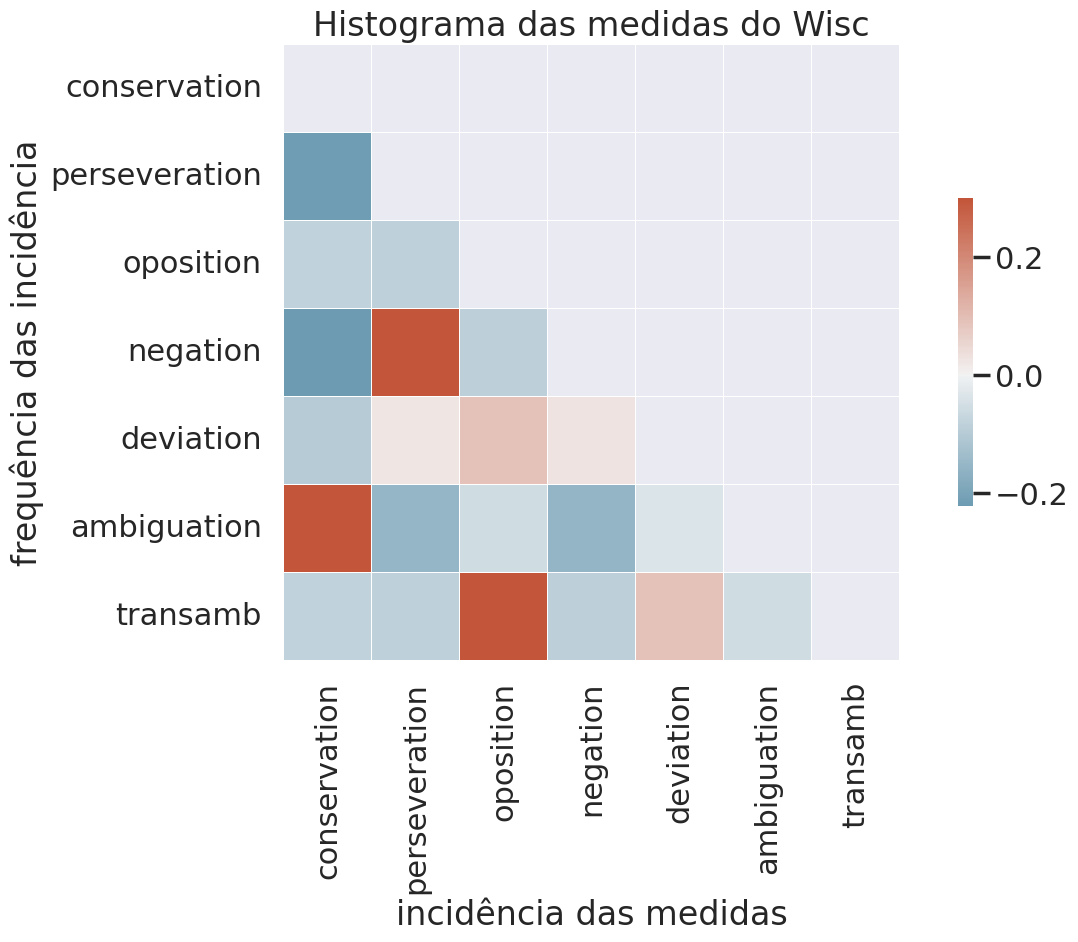

In [242]:
out = WiscPlot().retrieve_oid_from_person_df(person).heatmap(conf)


shape:  2 2


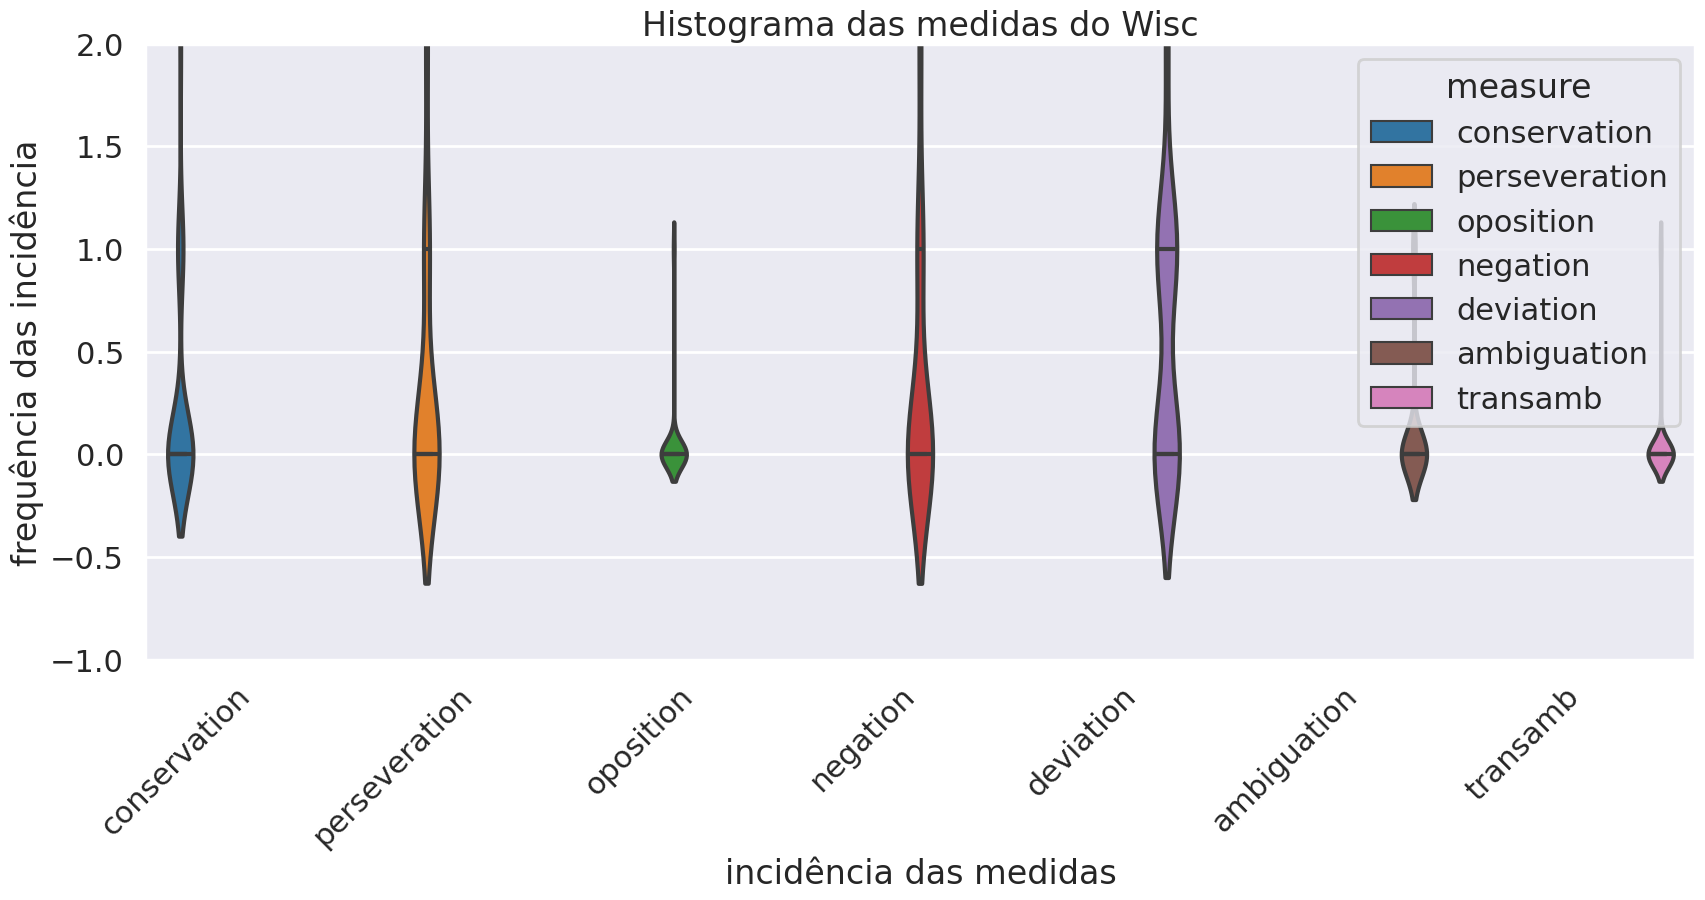

In [243]:
out = WiscPlot().retrieve_oid_from_person_df(person).violinplot(conf)


shape:  2 2


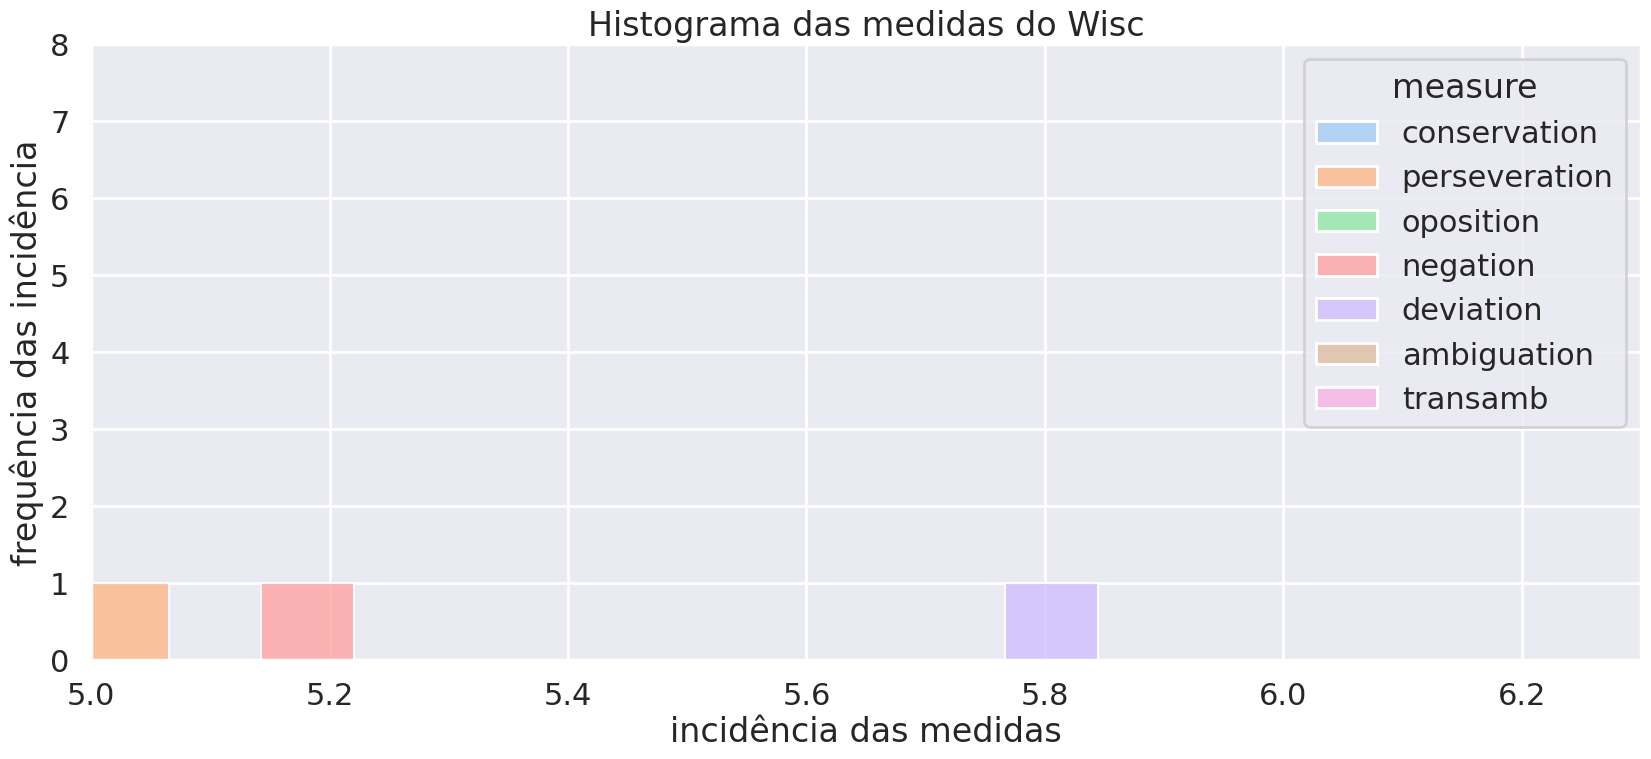

In [244]:

out = WiscPlot().retrieve_oid_from_person_df(person).histplot(conf)


shape:  2 2


ValueError: Could not interpret input 'ponto'

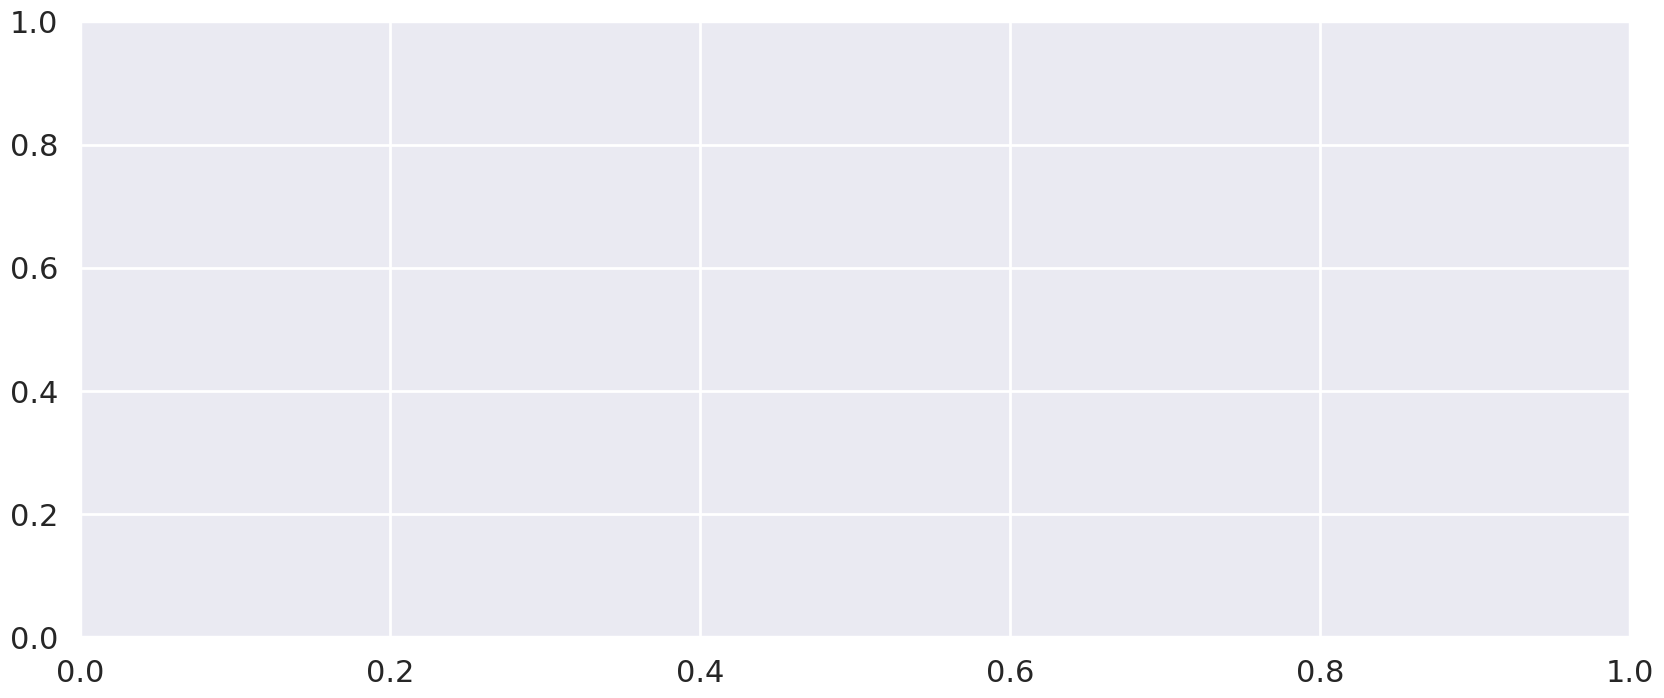

In [245]:
out = WiscPlot().retrieve_oid_from_person_df(person).plot(conf)
